##Step 1: Load and Preprocess Data

In [5]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load dataset (adjust path as needed)
df = pd.read_csv("Consumer_Complaints.csv")

# Filter only rows with complaint narrative and limit size (e.g., for testing)
df_clean = df[df['Consumer complaint narrative'].notnull()].copy().head(10000)

# Basic preprocessing function
def basic_preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b[x]{2,}\b', '', text)  # removes xxxx etc.
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and len(t) > 2]
    return ' '.join(tokens)

# Apply preprocessing
df_clean['clean_text'] = df_clean['Consumer complaint narrative'].apply(basic_preprocess)

# Show sample
print(df_clean[['Consumer complaint narrative', 'clean_text']].head())


                         Consumer complaint narrative  \
9   Started the refinance of home mortgage process...   
35  My wife and I visited the Chase Bank branch at...   
39  The service representative was harsh and not l...   
46  I have documentation that shows that US Bank w...   
54  Experian reporting of XXXX XXXX reflects a for...   

                                           clean_text  
9   started refinance home mortgage process cash o...  
35  wife visited chase bank branch open new checki...  
39  service representative harsh listening questio...  
46  documentation shows bank charge returned item ...  
54  experian reporting reflects foreflosure short ...  


##Step 2: Vectorization and Topic Modeling

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=20,
    stop_words='english',
    max_features=500
)

tfidf = tfidf_vectorizer.fit_transform(df_clean['clean_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 2: Define function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Step 3: NMF Topic Modeling
nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf)
print("NMF Topics:")
display_topics(nmf, feature_names, 10)

# Step 4: LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf)
print("\nLDA Topics:")
display_topics(lda, feature_names, 10)


NMF Topics:

Topic #1:
account bank card balance payment check chase fee closed money

Topic #2:
credit report reporting information equifax accounts removed experian remove reported

Topic #3:
debt collection collect agency owe company collector letter original validation

Topic #4:
loan payment mortgage payments loans modification home navient pay student

Topic #5:
told called phone number said asked did company calls calling

LDA Topics:

Topic #1:
account bank check money card told did called funds payment

Topic #2:
credit report account reporting information equifax accounts removed experian debt

Topic #3:
loan loans payment payments navient wells student pay fargo mortgage

Topic #4:
debt collection company phone calling calls number collect owe called

Topic #5:
card mortgage payment credit late loan account bank payments chase


##Step 3: Visualize Topics

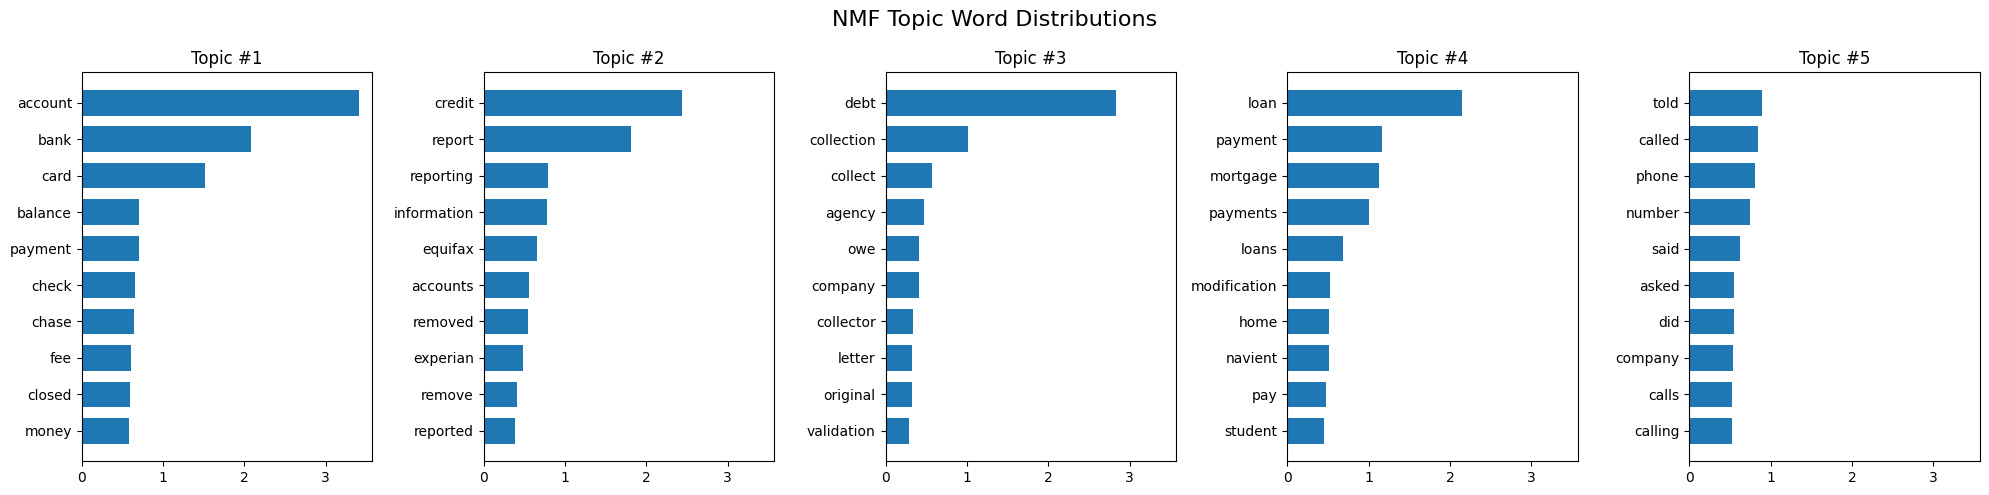

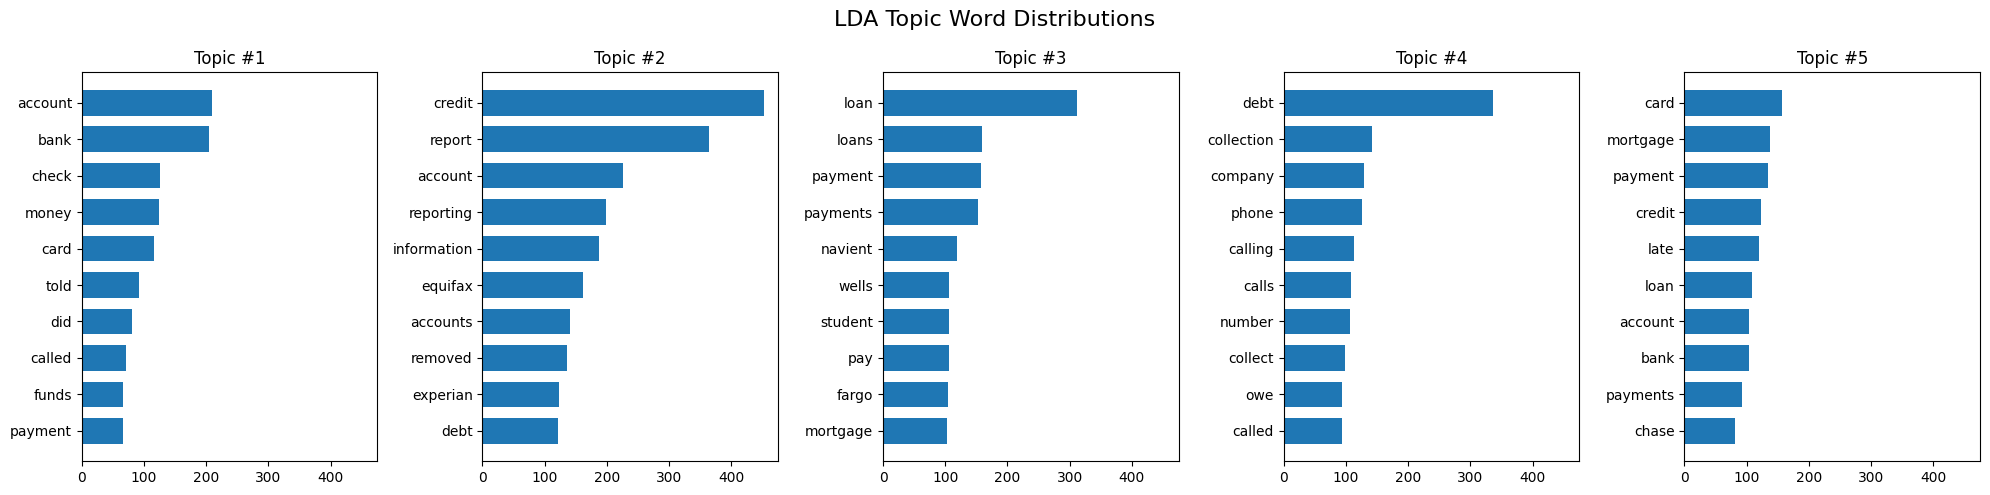

In [13]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, model.n_components, figsize=(20, 5), sharex=True)
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic #{topic_idx + 1}', fontsize=12)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot NMF topics
plot_top_words(nmf, feature_names, 10, 'NMF Topic Word Distributions')

# Plot LDA topics
plot_top_words(lda, feature_names, 10, 'LDA Topic Word Distributions')


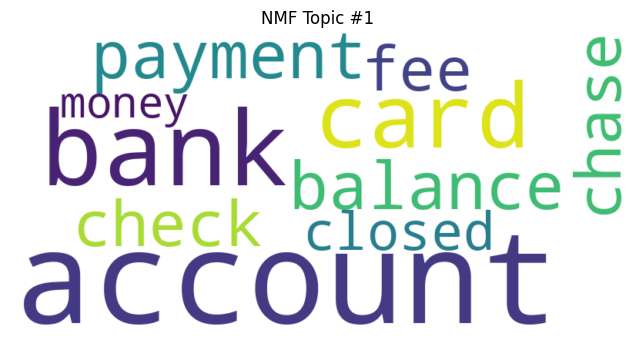

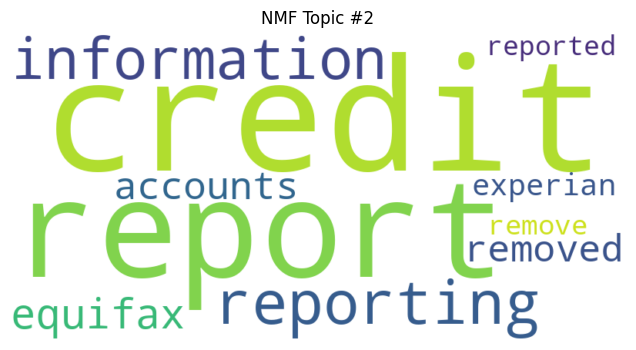

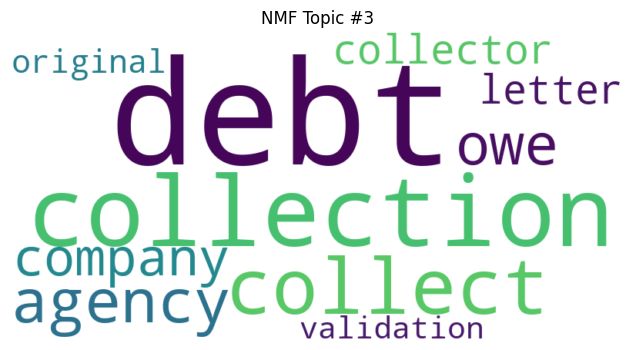

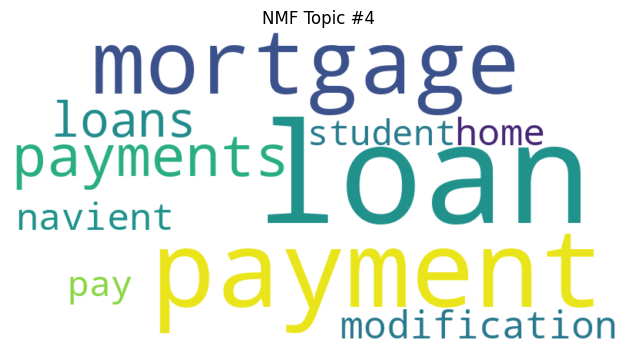

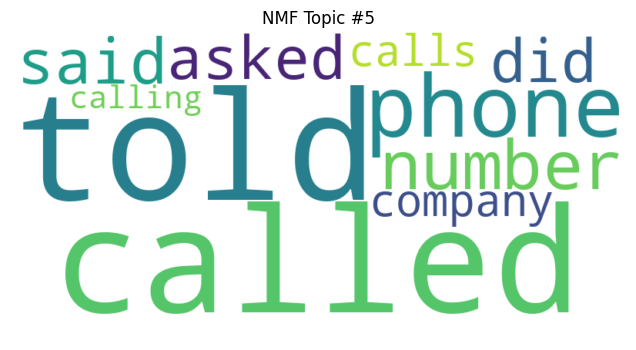

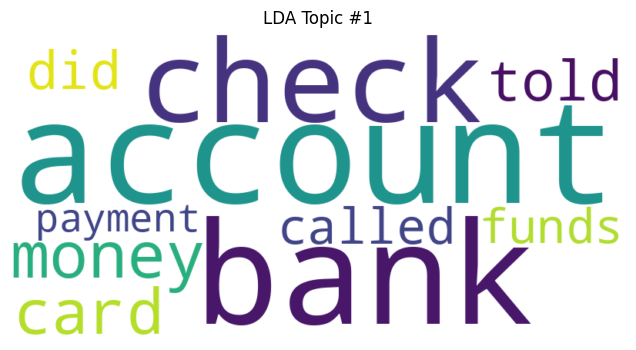

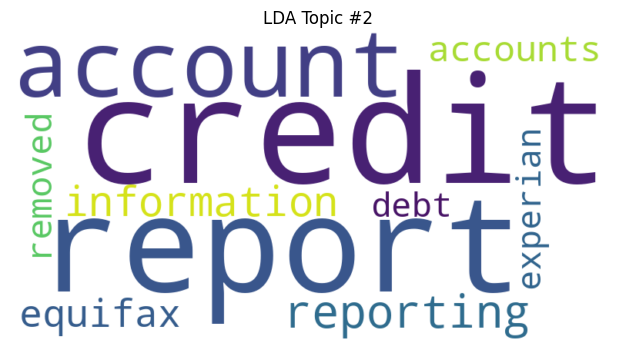

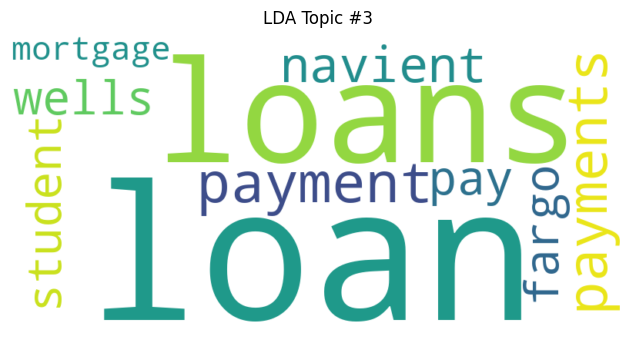

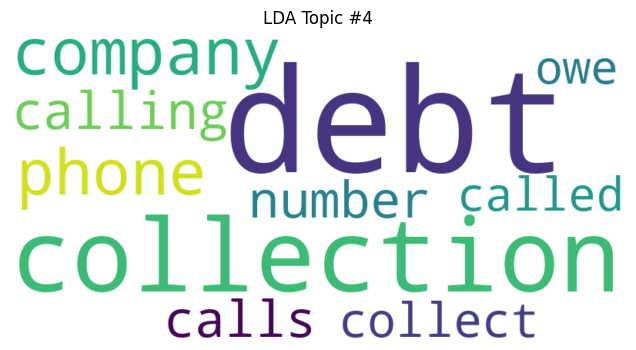

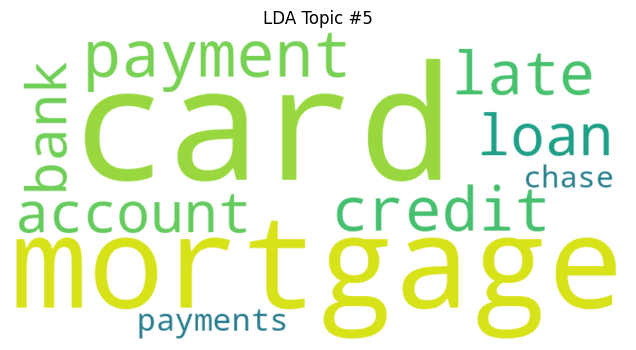

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def show_wordcloud(model, feature_names, n_top_words, title_prefix="Topic"):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_words = {feature_names[i]: topic[i] for i in top_features_ind}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{title_prefix} #{topic_idx + 1}")
        plt.show()

# Wordclouds for NMF and LDA
show_wordcloud(nmf, feature_names, 10, title_prefix="NMF Topic")
show_wordcloud(lda, feature_names, 10, title_prefix="LDA Topic")
